In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from utils import *

In [2]:
def jacobi_2nd(A, b, x0, tol=1e-8, max_iterations=1000):
    x = x0
    D = sparse.diags(A.diagonal()).tocsc()
    invD = sparse.linalg.inv(D)
    LU = A - D
    for k in range(max_iterations):     
        x_new = invD@(b - LU@x)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def gauess_seidel(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    L = sparse.tril(A)
    U = sparse.triu(A, 1)
    
    Linv = sparse.linalg.inv((L).tocsc())

    for k in range(max_iterations):     
        x_new = Linv @ (b - U@x)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def cg(A, b, x, tol=1e-8, max_iter=1000):
#     x = np.zeros_like(b, dtype=np.double)
    r = b - A@x
    p = r
    for k in range(max_iter):
        if np.linalg.norm(r) < tol:
            break
        alpha = (r.T@r)/(p.T@A@p)
        x_new = x + alpha * p
        r1 = r - alpha * A @ p
        beta = (r1.T@r1)/(r.T@r)
        p = r1 + beta * p
        r = r1    
        
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x_new


def my_cg(A, b, x, tol=1e-9, big_iter=100, small_iter=20):
    for k in range(big_iter):
        x_new = cg(A, b, x, max_iter=small_iter)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x
    


def descent(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b)
    r = b - A@x
    for k in range(max_iterations):
        alpha = (r.T@r)/(r.T@A@r)
        x_new = x + alpha * r
        r = b - A@x_new
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x
    

def sor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM = sparse.linalg.inv((D + w*L))
    
    for k in range(max_iterations):
        x_new = invM @ ((-w*U + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x

def ssor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM1 = sparse.linalg.inv((D + w*L).tocsc())
    invM2 = sparse.linalg.inv((D + w*U).tocsc())
    
    for k in range(max_iterations):
        x_half = invM1 @ ((-w*U + (1-w)*D)@x + w*b)
        x_new = invM2 @ ((-w*L + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x



def is_pos_def(x):
    return np.all(sparse.linalg.eigs(x)[0] > 0)

In [6]:
n = 121
a = 1
h = 2/(n-1)
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
xx, yy = np.meshgrid(x, y)
f = -normal(xx, yy, h)

A = fd_A_with_bc(n).tocsr()
# A = fd_A_neu(n).tocsr()
b = fd_b_bc(f, h)

w = spsolve(A, b).reshape(n, n)
# u = jacobi_2nd(A, b, x0=u.flatten()).reshape(n, n)
# u = sor(A, b, 0.9).reshape(n, n)
# u = ssor(A, b, 0.5).reshape(n, n)
# u = descent(A, b).reshape(n, n)
# u = cg(A, b, np.zeros_like(b), max_iter=1000).reshape(n, n)
# a = A.T@A
# c = A.T@b
u = my_cg(A, b, np.zeros_like(b), tol=1e-8, big_iter=5, small_iter=1500).reshape(n, n)
# u = cg(a, c, np.zeros_like(c)).reshape(n, n)


itr:0 Difference: 1.000e+00,  Loss:2.51e-01
itr:1 Difference: 4.916e-01,  Loss:2.31e-01
itr:2 Difference: 3.254e-01,  Loss:2.19e-01
itr:3 Difference: 2.456e-01,  Loss:2.06e-01
itr:4 Difference: 2.021e-01,  Loss:1.95e-01
itr:5 Difference: 1.720e-01,  Loss:1.85e-01
itr:6 Difference: 1.515e-01,  Loss:1.76e-01
itr:7 Difference: 1.354e-01,  Loss:1.69e-01
itr:8 Difference: 1.231e-01,  Loss:1.62e-01
itr:9 Difference: 1.127e-01,  Loss:1.56e-01
itr:10 Difference: 1.042e-01,  Loss:1.50e-01
itr:11 Difference: 9.683e-02,  Loss:1.45e-01
itr:12 Difference: 9.058e-02,  Loss:1.40e-01
itr:13 Difference: 8.497e-02,  Loss:1.36e-01
itr:14 Difference: 8.013e-02,  Loss:1.32e-01
itr:15 Difference: 7.572e-02,  Loss:1.29e-01
itr:16 Difference: 7.186e-02,  Loss:1.26e-01
itr:17 Difference: 6.830e-02,  Loss:1.23e-01
itr:18 Difference: 6.514e-02,  Loss:1.20e-01
itr:19 Difference: 6.221e-02,  Loss:1.17e-01
itr:20 Difference: 5.958e-02,  Loss:1.15e-01
itr:21 Difference: 5.713e-02,  Loss:1.12e-01
itr:22 Difference: 5

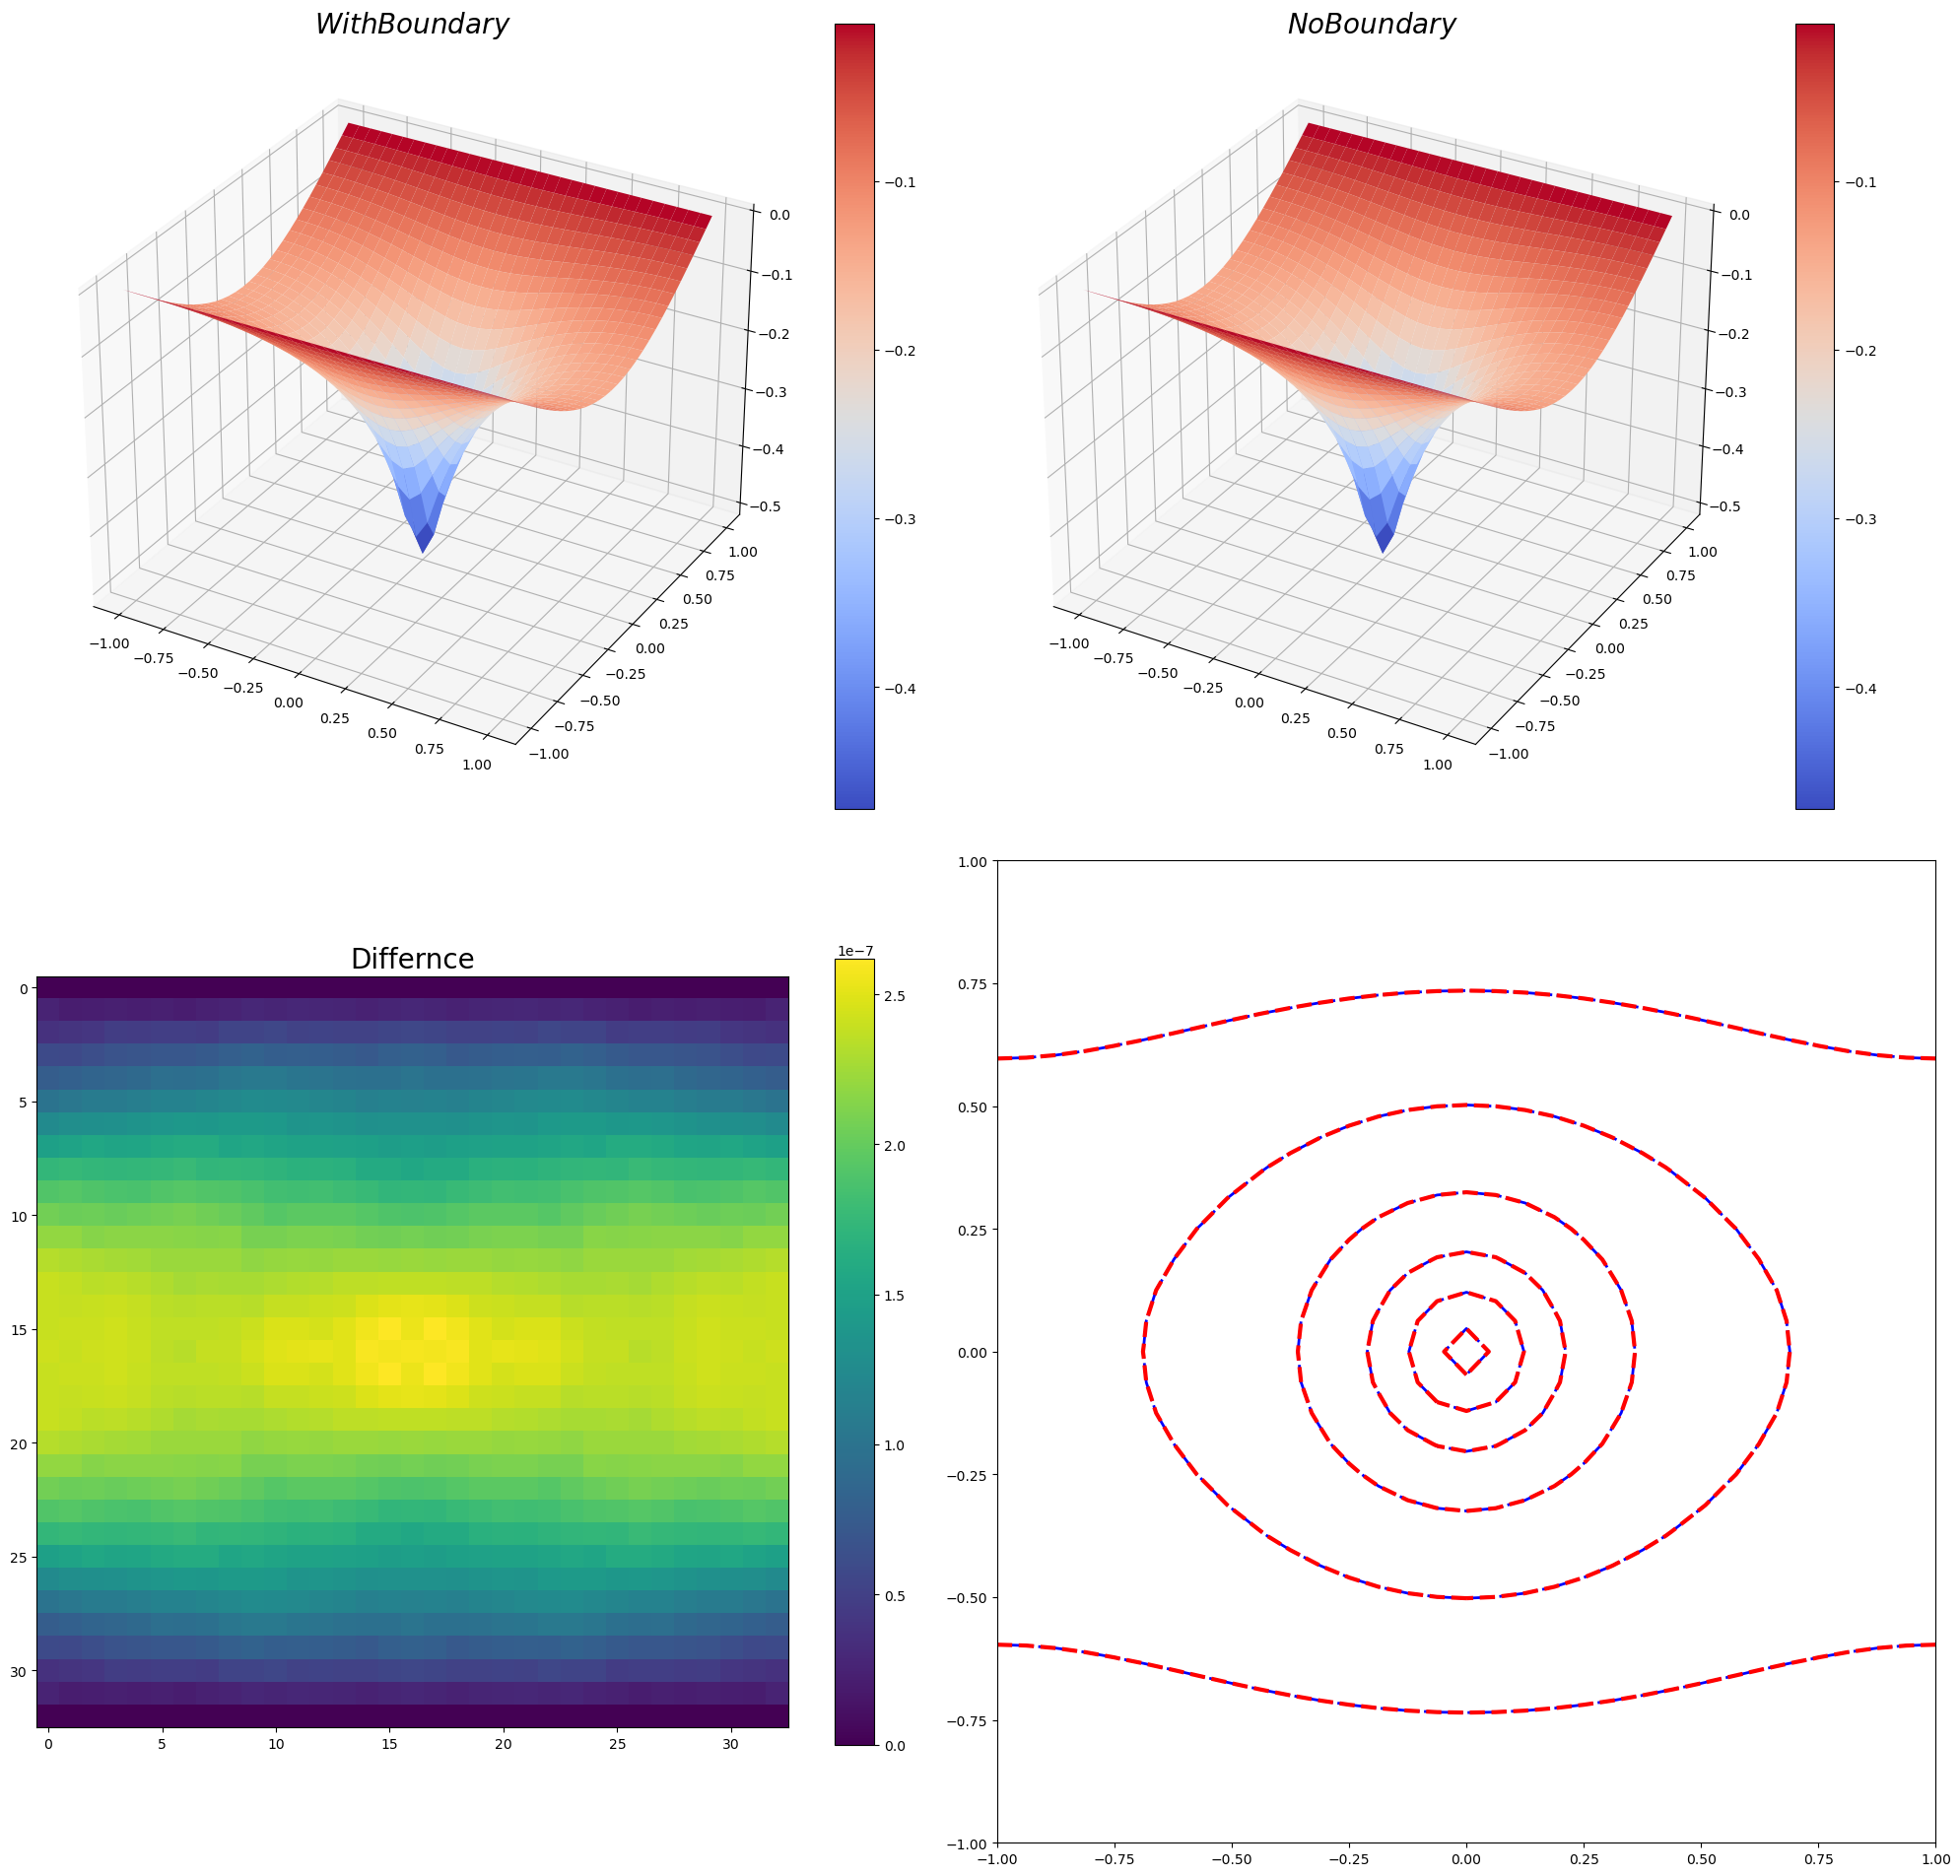

In [4]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.set_title(f'$With Boundary$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, w, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$No Boundary$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(np.abs(w - u))
plt.colorbar(im, shrink=0.8, ax=ax3)

ct1 = ax4.contour(xx, yy, w, colors='b', linewidths=2)
ct2 = ax4.contour(xx, yy, u, colors='r', linewidths=3)

fig.tight_layout()

In [5]:
def fv_mesh(a, N):
    h = 2*a / N
    left, bottom = -a + h/2, -a + h/2
    right, top = a - h/2, a - h/2
    
    x = np.linspace(left, right, N)
    y = np.linspace(bottom, top, N)
    return np.meshgrid(x, y)

def fv_b_func(a, N, f):
    h = 2*a / N
    xx, yy = fv_mesh(a, N)
    f_mat = f(xx, yy).flatten()
    return f_mat * h * h

def fv_b_point(N):
    b = np.zeros(N*N)
    idx = N//2 + N * (N//2)
    b[idx] = 1
    return b

def fv_A_dirichlet(n):
    n2 = n**2
    A = sparse.lil_matrix((n2, n2))
    # Interior points
    for i in range(1, n-1):
        for j in range(1, n-1):
            idx = i * n + j
            A[idx, idx] = -4
            A[idx, idx+1] = A[idx, idx-1] = A[idx, idx-n] = A[idx, idx+n] = 1
    
    # Boundary points
    for i in range(1, n-1):
        # Top
        idx = i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx+n] = 4/3
        
        # Bottom
        idx = (n-1) * n + i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx-n] = 4/3
        
        # Left
        idx = i * n
        A[idx, idx] = -6
        A[idx, idx+n] = A[idx, idx-n] = 1
        A[idx, idx+1] = 4/3
        
        # Right
        idx = i * n + n - 1
        A[idx, idx] = -6
        A[idx, idx+n] = A[idx, idx-n] = 1
        A[idx, idx-1] = 4/3
        
    # Four corners
    # Left top
    idx = 0
    A[idx, idx] = -8
    A[idx, idx+1] = A[idx, idx+n] = 4/3
    # Right Top
    idx = n-1
    A[idx, idx] = -8
    A[idx, idx-1] = A[idx, idx+n] = 4/3
    # Left Bottom
    idx = (n-1) * n
    A[idx, idx] = -8
    A[idx, idx+1] = A[idx, idx-n] = 4/3
    # Right Bottom
    idx = n2 - 1
    A[idx, idx] = -8
    A[idx, idx-1] = A[idx, idx-n] = 4/3
    
    A = A.tocoo()
    return A


def fv_A_neu(n):
    '''
    Left and Right are neumann, top and down are dirichlet
    '''
    n2 = n**2
    A = sparse.lil_matrix((n2, n2))
    # Interior points
    for i in range(1, n-1):
        for j in range(1, n-1):
            idx = i * n + j
            A[idx, idx] = -4
            A[idx, idx+1] = A[idx, idx-1] = A[idx, idx-n] = A[idx, idx+n] = 1
    
    # Boundary points
    for i in range(1, n-1):
        # Top
        idx = i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx+n] = 4/3
        
        # Bottom
        idx = (n-1) * n + i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx-n] = 4/3
        
        # Left
        idx = i * n
        A[idx, idx] = -3
        A[idx, idx+n] = A[idx, idx-n] = A[idx, idx+1] = 1
        
        # Right
        idx = i * n + n - 1
        A[idx, idx] = -3
        A[idx, idx+n] = A[idx, idx-n] = A[idx, idx-1] = 1
        
    # Four corners
    
    # Left top
    idx = 0
    A[idx, idx] = -5
    A[idx, idx+n] = 4/3
    A[idx, idx+1] = 1
    
    # Right Top
    idx = n-1
    A[idx, idx] = -5
    A[idx, idx+n] = 4/3
    A[idx, idx-1] = 1
    
    # Left Bottom
    idx = (n-1) * n
    A[idx, idx] = -5
    A[idx, idx-n] = 4/3
    A[idx, idx+1] = 1
    
    # Right Bottom
    idx = n2 - 1
    A[idx, idx] = -5
    A[idx, idx-n] = 4/3
    A[idx, idx-1] = 1
    
    A = A.tocoo()
    return A
        


In [6]:
a = 1
N = 65
h = 2*a/N

f = lambda x, y: normal(x, y, h)
xx, yy = fv_mesh(a, N)
A = fv_A_dirichlet(N).tocsr()
# A = fv_A_neu(N).tocsr()
b = fv_b_point(N)
# b = fv_b_func(a, N, f)
# print(A.todense())
w = spsolve(A, b).reshape(N, N)
# u = jacobi_2nd(A, b).reshape(N ,N)
# u = jacobi_2nd(A, b).reshape(N, N)
# u = sor(A, b, 1.2).reshape(N, N)
u = descent(A, b).reshape(N, N)
# u = ssor(A, b, 1.2).reshape(N, N)

itr:0 Difference: 1.000e+00,  Loss:5.00e-01
itr:1 Difference: 4.472e-01,  Loss:3.75e-01
itr:2 Difference: 2.727e-01,  Loss:3.12e-01
itr:3 Difference: 2.074e-01,  Loss:2.73e-01
itr:4 Difference: 1.628e-01,  Loss:2.46e-01
itr:5 Difference: 1.370e-01,  Loss:2.26e-01
itr:6 Difference: 1.166e-01,  Loss:2.09e-01
itr:7 Difference: 1.027e-01,  Loss:1.96e-01
itr:8 Difference: 9.099e-02,  Loss:1.85e-01
itr:9 Difference: 8.229e-02,  Loss:1.76e-01
itr:10 Difference: 7.467e-02,  Loss:1.68e-01
itr:11 Difference: 6.870e-02,  Loss:1.61e-01
itr:12 Difference: 6.335e-02,  Loss:1.55e-01
itr:13 Difference: 5.899e-02,  Loss:1.49e-01
itr:14 Difference: 5.502e-02,  Loss:1.44e-01
itr:15 Difference: 5.170e-02,  Loss:1.40e-01
itr:16 Difference: 4.864e-02,  Loss:1.36e-01
itr:17 Difference: 4.603e-02,  Loss:1.32e-01
itr:18 Difference: 4.359e-02,  Loss:1.29e-01
itr:19 Difference: 4.148e-02,  Loss:1.25e-01
itr:20 Difference: 3.950e-02,  Loss:1.22e-01
itr:21 Difference: 3.776e-02,  Loss:1.20e-01
itr:22 Difference: 3

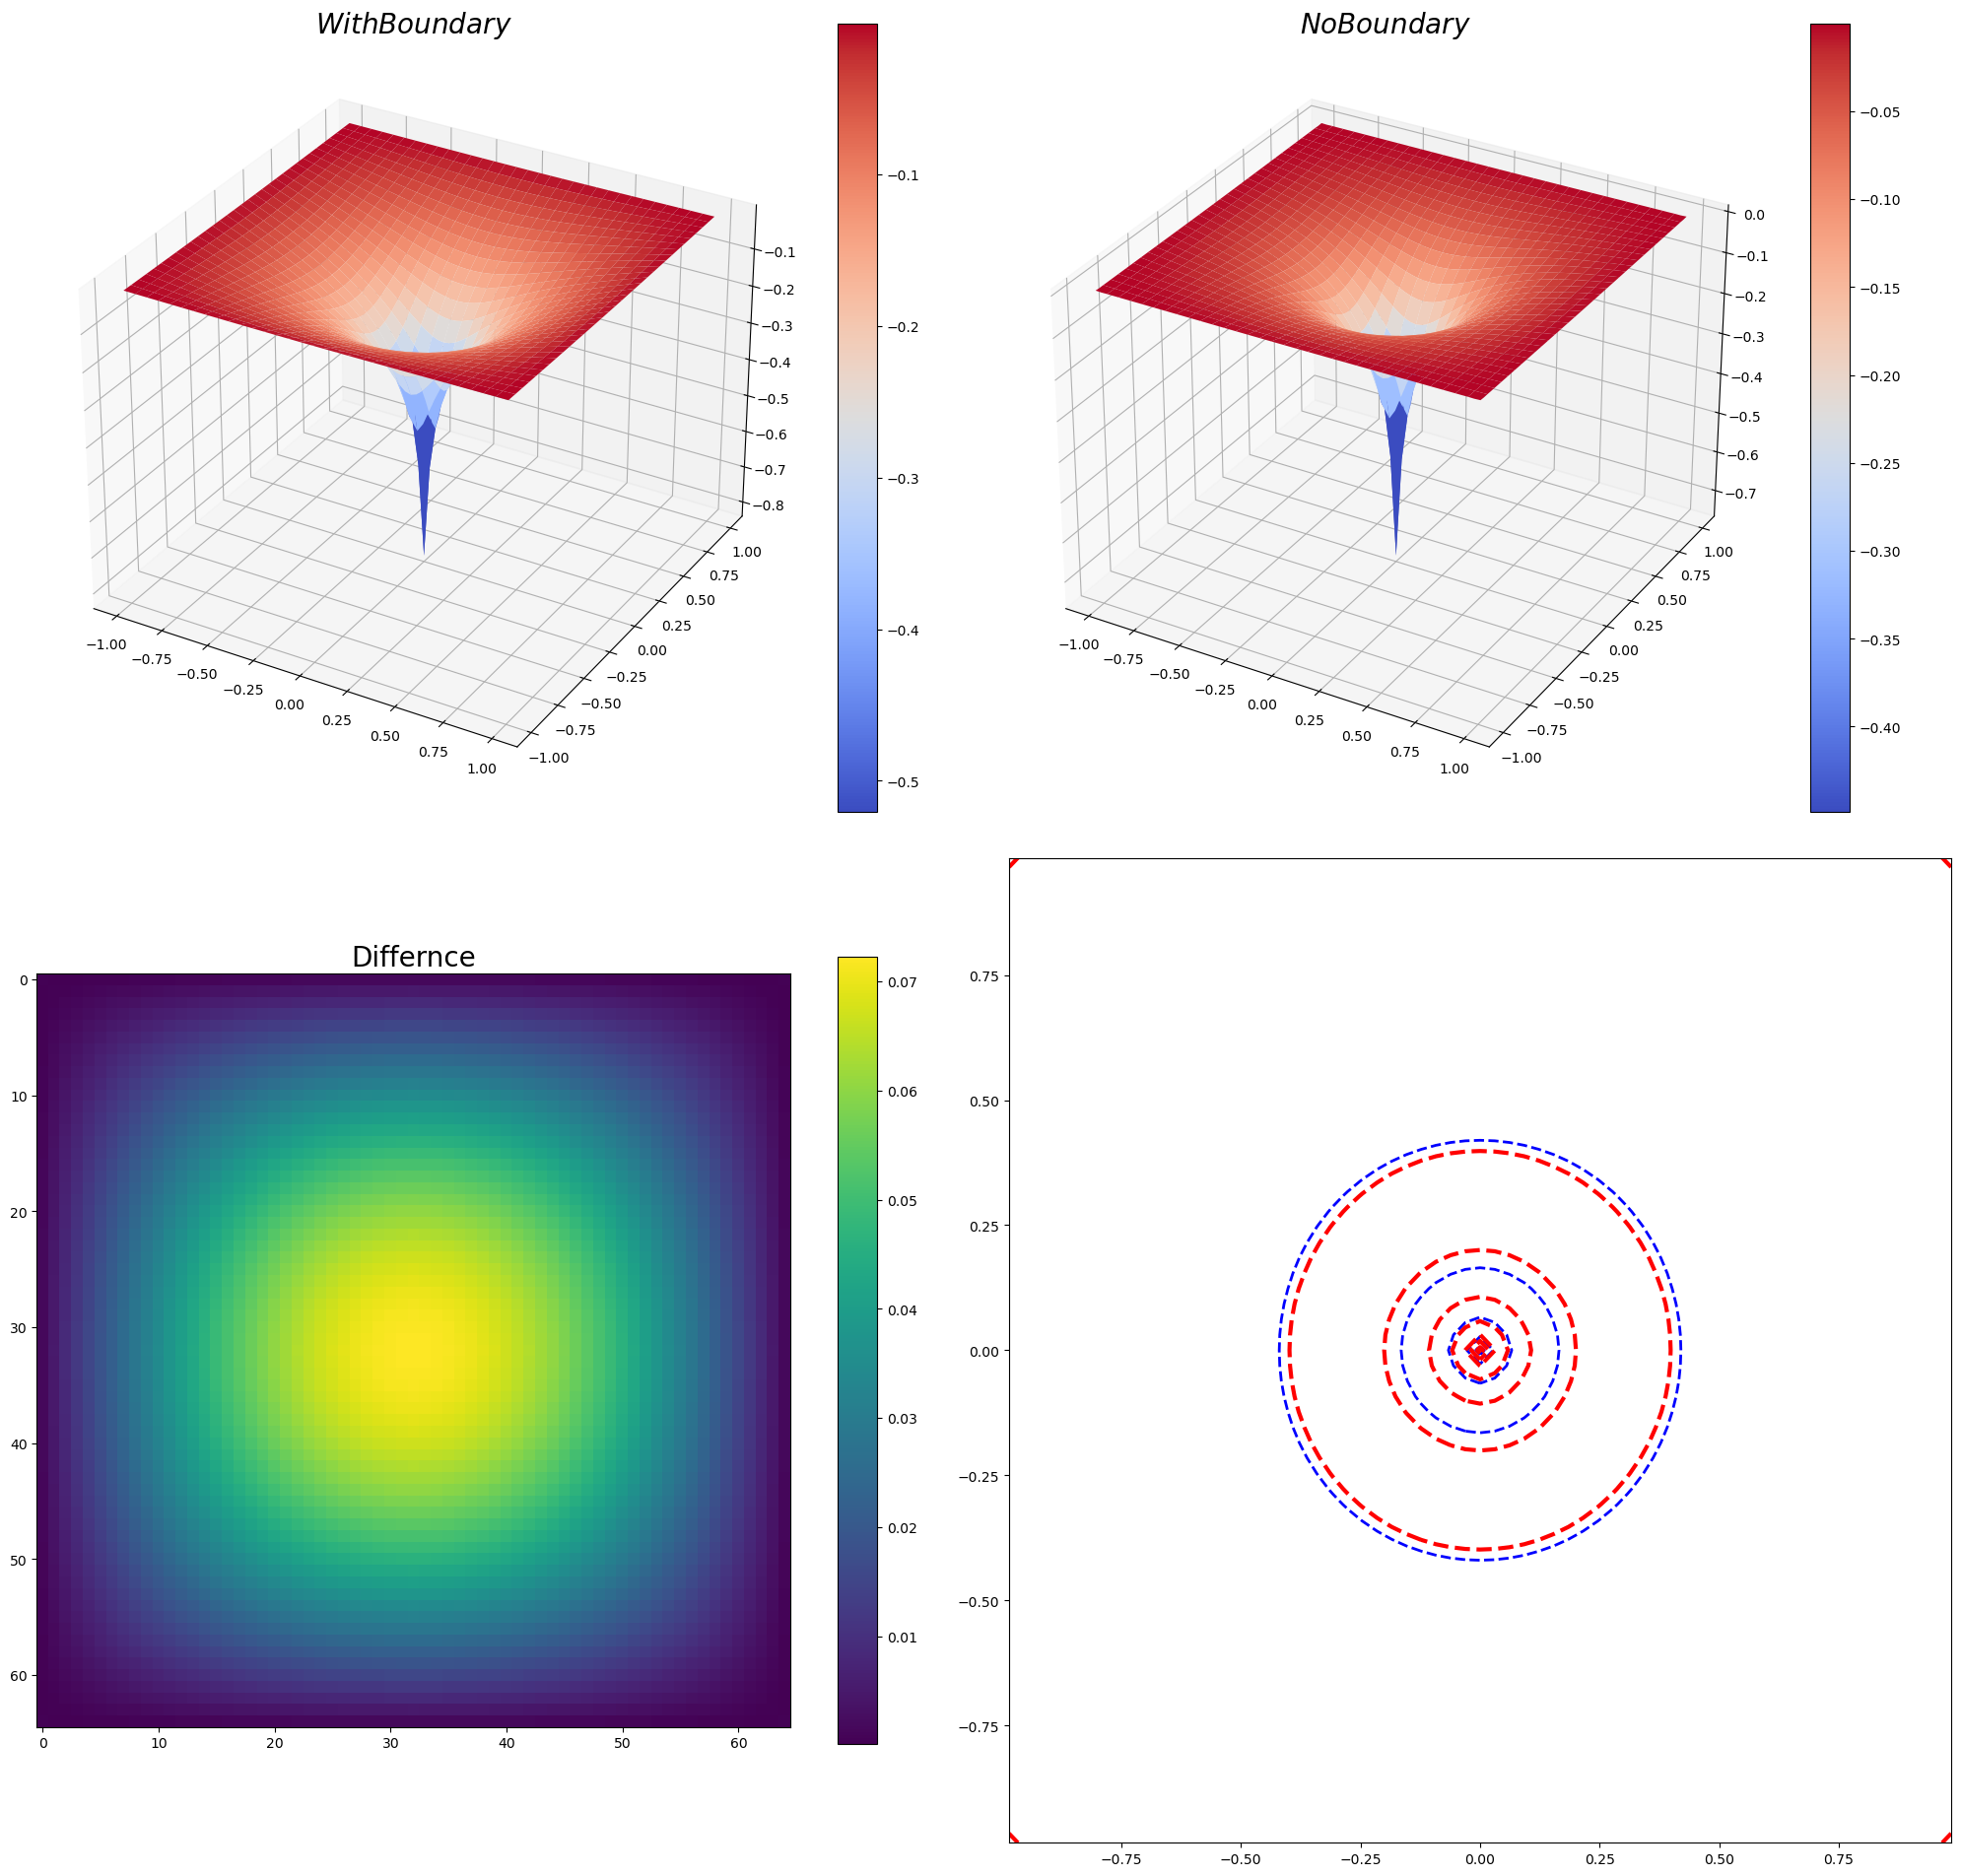

In [7]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.set_title(f'$With Boundary$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, w, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$No Boundary$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(np.abs(w - u))
plt.colorbar(im, shrink=0.8, ax=ax3)

ct1 = ax4.contour(xx, yy, w, colors='b', linewidths=2)
ct2 = ax4.contour(xx, yy, u, colors='r', linewidths=3)

fig.tight_layout()

In [8]:
from trainer import *

In [12]:
x = torch.rand(4, 1, 33, 33)
# y = pad_diri_bc(x, (1, 1, 0, 0), 0)
x = torch.flatten(x, 1, -1)
print(x.shape)
xx = bvi(x, x)
xx / xx

torch.Size([4, 1089])


tensor([1., 1., 1., 1.])

In [10]:
A = sparse.load_npz('../data/One33/AD.npz')
A = coo2tensor(A)

In [20]:
Ax = mmbv(A, x)
print(Ax.shape)
xx = xx.reshape(4, 1)
print(xx.shape)
y = xx * Ax
print(y.shape)
y[0] - xx[0] * Ax[0]

torch.Size([4, 1089])
torch.Size([4, 1])
torch.Size([4, 1089])


tensor([0., 0., 0.,  ..., 0., 0., 0.])